In [1]:
import xml.etree.ElementTree as ET
import os
import numpy as np
import glob

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as patheffects

import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [2]:
def getBBInfo(root):
    arrT= []
    for localObj in root.findall('object'):        
        xmin, ymin, xmax, ymax = 0, 0, 0, 0        
        for bndbox in localObj.find('bndbox'):            
            if bndbox.tag == "xmin": xmin = float(bndbox.text)
            if bndbox.tag == "ymin": ymin = float(bndbox.text)
            if bndbox.tag == "xmax": xmax = float(bndbox.text)
            if bndbox.tag == "ymax": ymax = float(bndbox.text)    
        arrT.append( [ xmin, ymin, xmax, ymax ] )
    return arrT
def setBBInfo(root, arrT):    
    for ind, localObj in enumerate( root.findall('object') ):        
        for bndbox in localObj.find('bndbox'):            
            if bndbox.tag == "xmin": bndbox.text = str( arrT[ind][0] )
            if bndbox.tag == "ymin": bndbox.text = str( arrT[ind][1] )
            if bndbox.tag == "xmax": bndbox.text = str( arrT[ind][2] )
            if bndbox.tag == "ymax": bndbox.text = str( arrT[ind][3] )

In [3]:
def setImageSize(root, imagesize):
    inner = root.find('size')
    inner.find('width').text = str(imagesize[0])
    inner.find('height').text = str(imagesize[1])

In [4]:
path = "D:/____Download"
tree = ET.parse(os.path.join(path, '02.xml'))
root = tree.getroot()
arrT = getBBInfo(root)
print("arrT", arrT)
setBBInfo(root, arrT)
setImageSize(root, (100, 200))

arrT [[890.0, 720.0, 1897.0, 1941.0], [3325.0, 1099.0, 3897.0, 2020.0]]


In [5]:
#metimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)


# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.ContrastNormalization((0.5, 2.0))
                    )
                ]),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        ),
        iaa.Resize((224,224))
    ],
    random_order=True
)

In [6]:
def bb_hw(a): return np.array([a[0],a[1],a[2]-a[0]+1,a[3]-a[1]+1])

def hw_xycxcy(a): return np.array( [a[0], a[1], a[0] + a[2] - 1,a[1] + a[3] - 1 ])

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, edgecolor='white'):    
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=edgecolor, lw=2))    
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [7]:
source = "D:/MyProject/PyTorch/rcnn/datas/original"
target = "D:/MyProject/PyTorch/rcnn/datas/augmented"

In [8]:
def augmentImage( origin_image_array, bbs, tree, target, onlyfilename ) :
    image_aug, bbs_aug = seq(image=origin_image_array, bounding_boxes=bbs)
    
    arrayBBoxSave = []
    for bb in bbs_aug.bounding_boxes:
        arrayBBoxSave.append( [int(bb.x1), int(bb.y1), int(bb.x2), int(bb.y2)] )                    
    
    imsiImageArray = Image.fromarray( image_aug )
    imsiImageArray.save( os.path.join(target, onlyfilename + ".jpg" ) )
    setImageSize(root, imsiImageArray.size )
    setBBInfo(root, arrayBBoxSave)        
    tree.write(os.path.join(target,onlyfilename + ".xml"))
    

In [9]:

arrFiles = glob.glob( os.path.join(source, "*.xml") )
for idx, xmlfile in enumerate(arrFiles):
    xmlname = xmlfile.split("\\")[-1]
    jpgname = xmlname.replace(".xml", ".jpg")
    onlyname = xmlname.replace(".xml","")        
    
    img = Image.open( os.path.join(source, jpgname) )
    origin_image_array = np.array( img )
    
    tree = ET.parse( xmlfile )
    root = tree.getroot()    
    
    arrayBBox = []
    for bb in getBBInfo(root):
        arrayBBox.append( BoundingBox(*bb) )
    bbs = BoundingBoxesOnImage( arrayBBox , shape=origin_image_array.shape)    
    
    for inner in range(5):
        augmentImage( origin_image_array, bbs, tree, target, "{}_{}".format(onlyname, inner ) )        

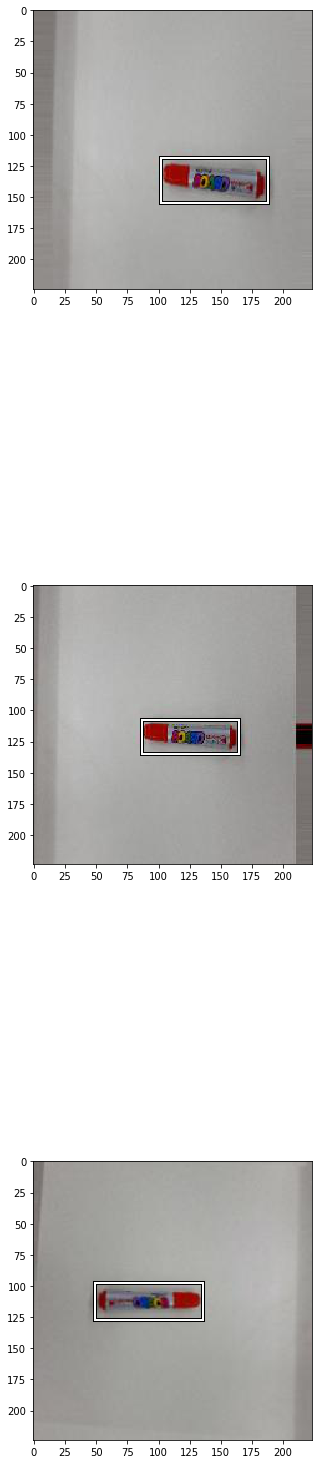

In [33]:
path = target
arrXmls = glob.glob( os.path.join(path, "*.xml"))

nStart = 40
nTotal = 3

fig,ax = plt.subplots(nTotal, 1, figsize=(5, nTotal * 10 ))
for ind in range( nStart, nStart + nTotal ):
    xml = arrXmls[ ind ]
    filename = xml.split("\\")[-1]
    onlyname = filename.replace(".xml", "")    
    ax[ind - nStart ].imshow( Image.open( path + "/" + onlyname + ".jpg") )        
    
    tree = ET.parse(os.path.join(xml))
    root = tree.getroot()
    arrT = getBBInfo(root)
    for tt in arrT:
        draw_rect(ax[ind - nStart], bb_hw( tt ) )
    